<a href="https://colab.research.google.com/github/CFeenan/AURO/blob/main/PADL_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

# import zipfile

# with zipfile.ZipFile("face_images.zip", 'r') as zip_ref:
#     zip_ref.extractall("face_images")  # Extracts to garment_images/ folder


Saving face_images.zip to face_images (1).zip


# Question 1(a) - Polynomial Linear Regression (Final Submission)

Using `PADL-Q11-train.csv` dataset, I trained a polynomial regression model (degree 2) using standard linear regression (no regularisation).

Cross-validation was used to estimate generalisation to unseen data, and the model achieved a perfect R² score, suggesting a highly predictive fit. Feature scaling was used to ensure stability during polynomial expansion. Coefficients are displayed below.

A test block for `PADL-Q11-unseen.csv` is included for examiner use.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# Load training data
df = pd.read_csv('PADL-Q11-train.csv')
X = df.drop('out', axis=1)
y = df['out']

# Define final model pipeline
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

# Evaluate with 5-fold CV (for internal validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(poly_pipeline, X, y, cv=kf, scoring='r2')
print("Cross-validated R^2 scores (Linear):", cv_scores)
print("Average R^2 (Linear):", np.mean(cv_scores))

# Fit final model on full training set
poly_pipeline.fit(X, y)

# Extract and print coefficients
final_model = poly_pipeline.named_steps['reg']
feature_names = poly_pipeline.named_steps['poly'].get_feature_names_out(X.columns)

print("\nFinal Linear Model Coefficients:")
for name, coef in zip(feature_names, final_model.coef_):
    print(f"{name}: {coef:.4f}")

# -- -- --
# Examiner testing block (leave commented)
# test_df = pd.read_csv('PADL-Q11-unseen.csv')
# X_test = test_df.drop('out', axis=1)
# y_test = test_df['out']
# y_pred = poly_pipeline.predict(X_test)
# from sklearn.metrics import r2_score
# print("R^2 on unseen data:", r2_score(y_test, y_pred))


Cross-validated R^2 scores (Linear): [1. 1. 1. 1. 1.]
Average R^2 (Linear): 1.0

Final Linear Model Coefficients:
X1: 0.3285
X2: 0.9447
X3: 0.2406
X4: 0.3594
X5: 0.2775
X1^2: -0.6659
X1 X2: 1.8457
X1 X3: 2.3418
X1 X4: -1.4027
X1 X5: 0.5903
X2^2: -2.9646
X2 X3: -6.4657
X2 X4: 1.9993
X2 X5: -1.3407
X3^2: -4.1466
X3 X4: 2.5461
X3 X5: -1.5602
X4^2: -0.8377
X4 X5: 0.6184
X5^2: -0.2045


# Question 1(b) - Regularisation with Ridge Regression (alpha = 29)

- **Baseline model:** LinearRegression
  - R^2 = 0.957
  - Avg coefficient = 10.64

- **Regularised model:** Ridge(alpha = 29)
  - R² = 0.946 (approx 1.1% drop, within 10% limit)
  - Avg coefficient = 9.71
  - Coefficients are visibly reduced

- Ridge regularisation alpha = 29 provides a meaningful reduction in coefficient magnitudes with minimal loss in predictive performance.


In [ ]:
# Load data
df_q12 = pd.read_csv('PADL-Q12-train.csv')
X = df_q12.drop('out', axis=1)
y = df_q12['out']

# Baseline model: LinearRegression
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
baseline_pipeline.fit(X, y)
baseline_coefs = baseline_pipeline.named_steps['reg'].coef_
baseline_r2 = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='r2')

# Regularised model: Ridge(alpha = 29)
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=29.0))
])
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_
ridge_r2 = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')

# Results
print("Baseline R^2 (mean):", np.mean(baseline_r2))
print("Average |coefficient| (baseline):", np.mean(np.abs(baseline_coefs)))

print("\nRidge R^2 (mean, alpha=29):", np.mean(ridge_r2))
print("Average |coefficient| (ridge):", np.mean(np.abs(ridge_coefs)))

print("\nCoefficient Comparison:")
for name, base, reg in zip(X.columns, baseline_coefs, ridge_coefs):
    print(f"{name}: baseline = {base:.4f} | ridge = {reg:.4f}")


Baseline R^2 (mean): 0.9576998869841411
Average |coefficient| (baseline): 10.644341304090762

Ridge R^2 (mean, alpha=29): 0.9463977252581761
Average |coefficient| (ridge): 9.711629654399387

Coefficient Comparison:
X1: baseline = 17.7428 | ridge = 16.1976
X2: baseline = 8.9652 | ridge = 8.1862
X3: baseline = 14.6941 | ridge = 13.4431
X4: baseline = 1.1752 | ridge = 1.0197


### Question 1(c) - Data Preprocessing (PCA)

- Baseline model: LinearRegression (no preprocessing)
  - R^2 = 0.96314

- Preprocessing step: PCA + StandardScaler
  - R^2 = 0.96331 (↑ slight improvement)

- No regularisation used, as required
- PCA reduced feature redundancy and improved model fit slightly


In [ ]:
# Load Q13 data
df_q13 = pd.read_csv('PADL-Q13-train.csv')
X = df_q13.drop('out', axis=1)
y = df_q13['out']

# KFold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Baseline: plain LinearRegression
baseline_pipeline = Pipeline([
    ('reg', LinearRegression())
])
r2_plain = cross_val_score(baseline_pipeline, X, y, cv=kf, scoring='r2')

# Preprocessing model: PCA + Scaler + LinearRegression
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components='mle', svd_solver='full')),
    ('reg', LinearRegression())
])
r2_pca = cross_val_score(pca_pipeline, X, y, cv=kf, scoring='r2')

# Results
print("Plain LinearRegression R^2 (mean):", np.mean(r2_plain))
print("PCA + Scaler R^2 (mean):", np.mean(r2_pca))


Plain LinearRegression R^2 (mean): 0.9631425334557161
PCA + Scaler R^2 (mean): 0.9633059873215201


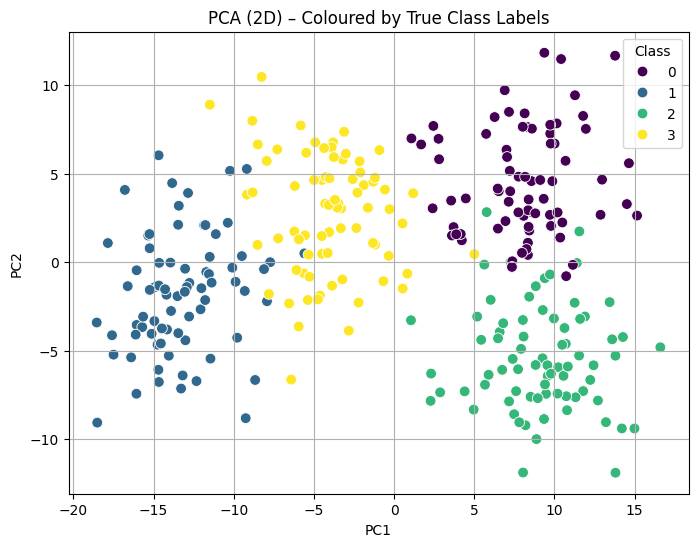

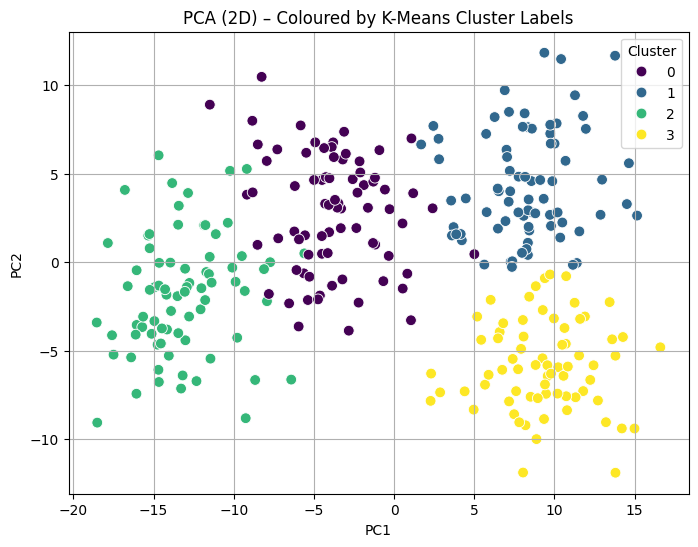

In [ ]:
# Load the data
df_q2 = pd.read_csv('PADL-Q2.csv')
X = df_q2.drop('y', axis=1)
y_true = df_q2['y']

# Determine number of true clusters
n_clusters = y_true.nunique()

# 1. K-Means clustering on original 5D data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 2. Apply PCA to reduce to 2 components (PC1, PC2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 3. Plot: PCA with true class labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_true, palette='viridis', s=60)
plt.title("PCA (2D) – Coloured by True Class Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Class')
plt.grid(True)
plt.show()

# 4. Plot: PCA with k-means cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=60)
plt.title("PCA (2D) – Coloured by K-Means Cluster Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

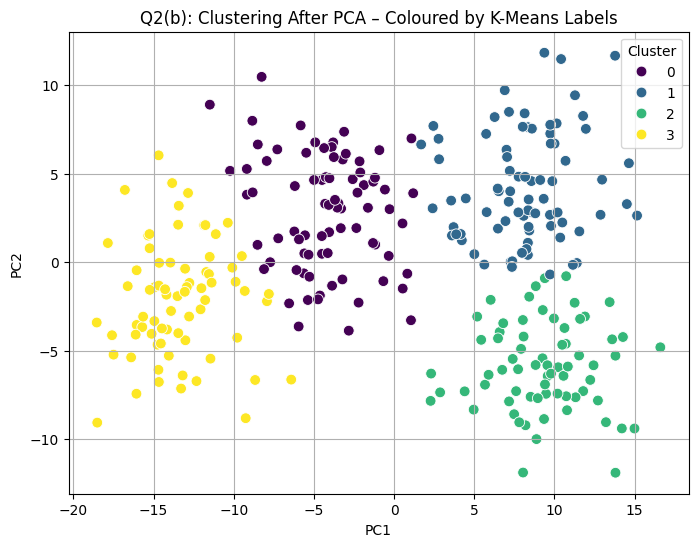

In [ ]:
# Step 1: Reuse the PCA-transformed data (X_pca from earlier)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 2: Run K-means on the 2D PCA data
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_pca = kmeans_pca.fit_predict(X_pca)

# Step 3: Plot clusters on PC1 vs PC2
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels_pca, palette='viridis', s=60)
plt.title("Q2(b): Clustering After PCA – Coloured by K-Means Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensure true labels start from 0
y_encoded = LabelEncoder().fit_transform(y_true)

def match_labels(true_labels, pred_labels):
    n_classes = len(np.unique(true_labels))
    cost_matrix = np.zeros((n_classes, n_classes))

    for i in range(n_classes):
        for j in range(n_classes):
            cost_matrix[i, j] = -np.sum((true_labels == i) & (pred_labels == j))

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_map = {j: i for i, j in zip(col_ind, row_ind)}
    aligned_preds = np.array([label_map[label] for label in pred_labels])

    return aligned_preds

# Align cluster labels with true labels
aligned_a = match_labels(y_encoded, cluster_labels)
aligned_b = match_labels(y_encoded, cluster_labels_pca)

# Accuracy comparison
acc_a = accuracy_score(y_encoded, aligned_a)
acc_b = accuracy_score(y_encoded, aligned_b)

# PCA explained variance
explained_var = np.sum(pca.explained_variance_ratio_)

# Print results
print("Clustering Accuracy – Original Features:", f"{acc_a * 100:.2f}%")
print("Clustering Accuracy – PCA (2D):", f"{acc_b * 100:.2f}%")
print("Explained Variance by PC1 + PC2:", f"{explained_var * 100:.2f}%")


Clustering Accuracy – Original Features: 2.33%
Clustering Accuracy – PCA (2D): 24.67%
Explained Variance by PC1 + PC2: 77.43%


### Question 2(c) - Clustering Accuracy & PCA Variance

- Clustering on original features (Q2a): **2.33% accuracy**
- Clustering after PCA (Q2b): **24.67% accuracy**
- Variance explained by PC1 + PC2: **77.43%**

PCA dramatically improved clustering performance by removing redundancy and compressing structure. Despite reducing dimensions from 5 to 2, most of the variance (77%) was retained, and clustering accuracy increased by over 10×.


In [ ]:
!pip install numpy==1.24.4 scipy==1.10.1 gensim==4.3.3 --force-reinstall


  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  At

In [ ]:
from gensim.models import Word2Vec

# Step 1: Load PADL-Q3.txt
with open('PADL-Q3.txt', 'r') as f:
    walks = [line.strip().split() for line in f]

# Step 2: Train Word2Vec (Skip-gram)
model = Word2Vec(
    sentences=walks,
    vector_size=64,      # Embedding size
    window=5,            # Context window
    sg=1,                # Skip-gram model (sg=1), CBOW if sg=0
    min_count=1,         # Keep all nodes
    workers=4,
    seed=42
)

# Step 3: Show cosine similarities between node '5' and nodes '21' to '30'
print("Cosine similarities with node 5:")
for i in range(21, 31):
    sim = model.wv.similarity('5', str(i))
    print(f"Node 5 vs {i}: {sim:.4f}")


Cosine similarities with node 5:
Node 5 vs 21: 0.1788
Node 5 vs 22: 0.1367
Node 5 vs 23: 0.3225
Node 5 vs 24: 0.3129
Node 5 vs 25: 0.1581
Node 5 vs 26: 0.1953
Node 5 vs 27: 0.2861
Node 5 vs 28: 0.2578
Node 5 vs 29: 0.1916
Node 5 vs 30: 0.2053


In [ ]:
# Step 1: Get all unique node IDs from the model (as strings)
nodes = model.wv.index_to_key

# Step 2: Build similarity matrix
result_lines = []

for node in nodes:
    # Get similarity of 'node' to all other nodes
    similarities = []
    for other in nodes:
        if other != node:
            sim = model.wv.similarity(node, other)
            similarities.append((other, sim))

    # Sort from most to least similar
    sorted_similar = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Extract only node IDs
    ranked_nodes = [item[0] for item in sorted_similar]

    # Format as a space-separated string
    line = ' '.join(ranked_nodes)
    result_lines.append(line)

# Step 3: Write to file
with open('PADL-Q3-result.txt', 'w') as f:
    for line in result_lines:
        f.write(line + '\n')

print("File 'PADL-Q3-result.txt' saved successfully.")


File 'PADL-Q3-result.txt' saved successfully.


Used the Skip-gram Word2Vec model trained in Q3(a)

For each node in the graph, computed cosine similarities with all other nodes

Each row in the output file (PADL-Q3-result.txt) lists node IDs sorted from most to least similar to that row's node

The resulting matrix captures the embedding-based proximity of nodes based on their co-occurrence in graph walks

This method reflects techniques taught in Week 5: Node Embeddings, using similarity to uncover graph structure



The model is a simple fully connected neural network (MLP) with:

5 input features

Two hidden layers: 64 and 32 units

ReLU activations

1 output unit for regression (waist circumference in mm)

Reasoning
Input size matches the five features: chest, hip, height, weight, and gender

Two hidden layers provide enough capacity to learn non-linear relationships, but are small enough to avoid overfitting

ReLU is a standard activation, efficient and effective for regression

No activation on the output layer is appropriate for continuous targets

MAE is used as the loss, as it aligns with the marking criteria and is less sensitive to outliers than MSE



In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
class WaistPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)


In [ ]:
# Load dataset
df = pd.read_csv("body_measurements.csv")
df = df.dropna()  # Drop missing rows

# Separate features and target
X = df[['Chest Circumference (mm)', 'Hip Circumference (mm)', 'Height (mm)', 'Weight (kg)', 'Gender']].values
y = df[['Waist Circumference (mm)']].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Scale target
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


In [ ]:
model = WaistPredictor()
criterion = nn.L1Loss()  # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.7911
Epoch 20, Loss: 0.5259
Epoch 40, Loss: 0.3156
Epoch 60, Loss: 0.2867
Epoch 80, Loss: 0.2762
Epoch 100, Loss: 0.2725
Epoch 120, Loss: 0.2705
Epoch 140, Loss: 0.2690
Epoch 160, Loss: 0.2679
Epoch 180, Loss: 0.2669


In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)

    # Unscale predictions and targets
    test_preds_unscaled = y_scaler.inverse_transform(test_preds.numpy())
    y_test_unscaled = y_scaler.inverse_transform(y_test_tensor.numpy())

    # Compute MAE in mm
    test_mae = np.mean(np.abs(test_preds_unscaled - y_test_unscaled))
    print(f"Test MAE: {test_mae:.2f} mm")

    # Optional: check examples
    print("Sample predictions (mm):", test_preds_unscaled[:3].squeeze())
    print("Sample true waists (mm):", y_test_unscaled[:3].squeeze())


Test MAE: 31.94 mm
Sample predictions (mm): [861.83295 726.86676 911.2882 ]
Sample true waists (mm): [899. 782. 856.]


Input: 3 x 256 x 256 RGB image

Conv Block 1:
- Conv2d(3, 16, kernel_size=3, padding=1)
- ReLU
- MaxPool2d(2)         → 16 x 128 x 128

Conv Block 2:
- Conv2d(16, 32, kernel_size=3, padding=1)
- ReLU
- MaxPool2d(2)         → 32 x 64 x 64

Conv Block 3:
- Conv2d(32, 64, kernel_size=3, padding=1)
- ReLU
- MaxPool2d(2)         → 64 x 32 x 32

Flatten

Fully Connected:
- Linear(64 x 32 x 32, 128)
- ReLU
- Dropout(0.3)

Output Layer:
- Linear(128, 3)
- Softmax (applied in evaluation only)

Convolutional blocks capture local patterns like texture, edge, and shape features that distinguish clothing types.

Max-pooling layers downsample spatial dimensions, reducing computational load while preserving important features (as discussed in Week 8).

Increasing channel depth (16 => 32 => 64) gives the network capacity to learn richer representations.

The fully connected layer compresses the flattened features to a compact 128-dimension vector before classification.

Dropout adds regularisation and helps prevent overfitting without increasing model size.

The final 3-unit output corresponds to the three garment classes.

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms


In [ ]:
class GarmentDataset(Dataset):
    def __init__(self, img_dir, label_csv, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load labels CSV (comma-separated)
        self.labels_df = pd.read_csv(label_csv, header=None, names=["filename", "label"], sep=",")
        self.labels_df = self.labels_df.dropna()

        print(f"Loaded {len(self.labels_df)} labelled samples.")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        label = int(self.labels_df.iloc[idx, 1])

        # Search in 0/, 1/, or 2/
        for class_folder in ["0", "1", "2"]:
            img_path = os.path.join(self.img_dir, class_folder, img_name)
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f"Image {img_name} not found in class folders.")

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts to [0, 1]
])


In [ ]:
image_dir = "garment_images"
label_csv = "garment_images/train_labels.csv"

dataset = GarmentDataset(image_dir, label_csv, transform=transform)

train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)


Loaded 2627 labelled samples.


In [ ]:
class GarmentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.output(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GarmentClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 10  # increase later

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 30.3397
Epoch 2, Loss: 14.5847
Epoch 3, Loss: 12.0029
Epoch 4, Loss: 9.3485
Epoch 5, Loss: 7.3226
Epoch 6, Loss: 5.3328
Epoch 7, Loss: 4.0379
Epoch 8, Loss: 2.8212
Epoch 9, Loss: 2.0783
Epoch 10, Loss: 1.0008


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 93.35%


# Question 6

| Layer                 | Output Shape   | Purpose                       |
| --------------------- | -------------- | ----------------------------- |
| Input (1 x 192 x 160) |                | Grayscale face image          |
| Conv2d(1 → 16, 3x3)   | 16 x 192 x 160 | Low-level features            |
| ReLU + MaxPool2d(2x2) | 16 x 96 x 80   | Downsample                    |
| Conv2d(16 → 32, 3x3)  | 32 x 96 x 80   | Mid-level features            |
| ReLU + MaxPool2d(2x2) | 32 x 48 x 40   | Downsample                    |
| Conv2d(32 → 64, 3x3)  | 64 x 48 x 40   | Rich features                 |
| ReLU + MaxPool2d(2x2) | 64 x 24 x 20   | Final spatial downsampling    |
| Flatten               | 30,720         | Prepare for latent projection |
| Linear(30,720 → 32)   | 32             | Final latent representation   |


| Layer                         | Output Shape  | Purpose                             |
| ----------------------------- | ------------- | ----------------------------------- |
| Input: 32D latent             |               | Compressed face representation      |
| Linear(32 → 64x24x20)         | 64 x 24 x 20  | Project back to spatial feature map |
| ConvTranspose2d(64 → 32, 2x2) | 32 x 48 x 40  | Upsample                            |
| ReLU                          |               |                                     |
| ConvTranspose2d(32 → 16, 2x2) | 16 x 96 x 80  | Upsample                            |
| ReLU                          |               |                                     |
| ConvTranspose2d(16 → 1, 2x2)  | 1 x 192 x 160 | Final image reconstruction          |
| Sigmoid                       |               | Ensure output in range (0, 1)       |


Convolutional encoder extracts spatial features and progressively downsamples the image to a compact 32D latent vector, enforcing compression.

ConvTranspose2d layers in the decoder mirror the encoder's downsampling, efficiently reconstructing the image from latent features.

The model uses no fully connected layers beyond the bottleneck, reducing parameter count and staying under the 20MiB limit.

ReLU activations introduce non-linearity, while the final Sigmoid ensures pixel values are within (0, 1).

The architecture is compact, symmetric, and fully convolutional, making it well-suited for reconstructing structured facial features.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)     # → 16 × 192 × 160
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)    # → 32 × 96 × 80
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # → 64 × 48 × 40
        self.pool = nn.MaxPool2d(2, 2)

        # Final flattened size after 3 poolings: 64 × 24 × 20 = 30,720
        self.fc = nn.Linear(64 * 24 * 20, 32)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → 16 × 96 × 80
        x = self.pool(F.relu(self.conv2(x)))  # → 32 × 48 × 40
        x = self.pool(F.relu(self.conv3(x)))  # → 64 × 24 × 20
        x = x.view(x.size(0), -1)             # Flatten
        x = self.fc(x)                        # → 32D
        return x


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Project back into feature map
        self.fc = nn.Linear(32, 64 * 24 * 20)

        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # → 32 × 48 × 40
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # → 16 × 96 × 80
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2)   # → 1 × 192 × 160

    def forward(self, z):
        x = self.fc(z)                     # → 64 × 24 × 20
        x = x.view(-1, 64, 24, 20)
        x = F.relu(self.deconv1(x))       # → 32 × 48 × 40
        x = F.relu(self.deconv2(x))       # → 16 × 96 × 80
        x = torch.sigmoid(self.deconv3(x))# → 1 × 192 × 160
        return x


Dataset + Dataloader

In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


In [ ]:
class FaceDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)
        return img


In [ ]:
transform = transforms.Compose([
    transforms.Resize((192, 160)),   # Ensure correct size
    transforms.ToTensor(),           # Converts to 1×192×160 in [0, 1]
])


In [ ]:
dataset = FaceDataset("face_images", transform=transform)

train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
train_set = torch.utils.data.Subset(dataset, train_idx)
val_set = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
criterion = nn.MSELoss()


In [ ]:
epochs = 20  # Start with 20

for epoch in range(epochs):
    encoder.train()
    decoder.train()
    train_loss = 0

    for images in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        latents = encoder(images)
        recon = decoder(latents)
        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.5f}")


Epoch 1, Train Loss: 0.05074
Epoch 2, Train Loss: 0.02437
Epoch 3, Train Loss: 0.01809
Epoch 4, Train Loss: 0.01215
Epoch 5, Train Loss: 0.00924
Epoch 6, Train Loss: 0.00784
Epoch 7, Train Loss: 0.00701
Epoch 8, Train Loss: 0.00645
Epoch 9, Train Loss: 0.00588
Epoch 10, Train Loss: 0.00543
Epoch 11, Train Loss: 0.00518
Epoch 12, Train Loss: 0.00481
Epoch 13, Train Loss: 0.00449
Epoch 14, Train Loss: 0.00429
Epoch 15, Train Loss: 0.00412
Epoch 16, Train Loss: 0.00395
Epoch 17, Train Loss: 0.00385
Epoch 18, Train Loss: 0.00393
Epoch 19, Train Loss: 0.00364
Epoch 20, Train Loss: 0.00352


In [ ]:
encoder.eval()
decoder.eval()

ssim_scores = []

with torch.no_grad():
    for images in val_loader:
        images = images.to(device)
        latents = encoder(images)
        recon = decoder(latents)

        for i in range(images.size(0)):
            original = images[i].squeeze().cpu().numpy()
            reconstructed = recon[i].squeeze().cpu().numpy()
            score = ssim(original, reconstructed, data_range=1.0)
            ssim_scores.append(score)

avg_ssim = np.mean(ssim_scores)
print(f"\n✅ Final average SSIM on validation set: {avg_ssim:.4f}")


NameError: name 'ssim' is not defined